# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post]() by yhat. Please feel free to refer to the post for additional information, and solutions.

In [41]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

The dataset contains both information on marketing newsletters/e-mail campaigns (e-mail offers sent) and transaction level data from customers (which offer customers responded to and what they bought).

In [11]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
print(df_offers.head())
print(len(df_offers))

   offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

  past_peak  
0     False  
1     False  
2      True  
3      True  
4      True  
32


In [84]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
print((df_transactions.head()))

  customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

**Your turn:** Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):

* customer_name
* One column for each offer, with a 1 if the customer responded to the offer

In [126]:
#your turn

all_cust_names = df_transactions['customer_name']
cust_names = unique(all_cust_names)
length = len(cust_names)
offerids_names = []
i = 1
for i in range(1,33):
    name = 'offerid'+str(i)
    offerids_names.append(name)
    
offer_lists = np.zeros(shape=(100,32), dtype=int64)
names_df = pd.DataFrame(cust_names, columns=['customer_name'])
offers_df = pd.DataFrame(offer_lists, columns=offerids_names)

clustering_input_df = names_df.append(offers_df)
clustering_input_df = clustering_input_df.fillna(0)

for index, trans in df_transactions.iterrows():
    cust_name = trans['customer_name']
    offerid = trans['offer_id']
    idx = clustering_input_df[clustering_input_df['customer_name'] == cust_name].index.tolist()
    offer_columnname = 'offerid'+str(offerid)
    clustering_input_df[offer_columnname][idx[0]] = int(1)
    offer_lists[idx[0]][offerid-1] = 1
    
clustering_input_df.head()

/home/roopireddy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,customer_name,offerid1,offerid10,offerid11,offerid12,offerid13,offerid14,offerid15,offerid16,offerid17,...,offerid3,offerid30,offerid31,offerid32,offerid4,offerid5,offerid6,offerid7,offerid8,offerid9
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## K-Means Clustering

**Your turn:** 

* Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
* Apply the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. Use `n_clusters=5` (but feel free to play with this)
* Print the number of points in each cluster 

In [169]:
#your turn
from sklearn.cluster import KMeans

cluster_predict = KMeans(n_clusters=5).fit_predict(offer_lists)
#print(cluster_predict)

cluster_df = pd.DataFrame({'customer_name': cust_names, 'clusterid': (cluster_predict+1)})
test = cluster_df.groupby('clusterid').count()
print(test)

           customer_name
clusterid               
1                     16
2                     10
3                     35
4                     25
5                     14


## Visualizing clusters using PCA

How do we visualize clusters? Principal Component Analysis (PCA) will help. There are lots of uses for PCA, but today we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset. Why you ask? Well once it is in 2 dimensions (or simply put, it has 2 columns), it becomes much easier to plot!

**Your turn:** Use PCA to plot your clusters:

* Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
* Create a data frame with the following fields:
  * customer name
  * cluster id the customer belongs to
  * the two PCA components (label them `x` and `y`)

In [170]:
#your turn

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(offer_lists)

pre_pca_df = pd.DataFrame(pca_components, columns=['x', 'y'])
pre_pca_df.head()

cluster_df['x'] = pre_pca_df['x']
cluster_df['y'] = pre_pca_df['y']

cluster_df.head(10)

,clusterid,customer_name,x,y
0,4,Adams,-1.007580,0.108215
1,3,Allen,0.287539,0.044715
2,1,Anderson,0.392032,1.038391
3,4,Bailey,-0.699477,-0.022542
4,5,Baker,-0.088183,-0.471695
5,5,Barnes,0.485282,-0.725503
6,1,Bell,0.591941,1.506500
7,4,Bennett,-0.661732,0.090308
8,3,Brooks,0.118943,-0.577499
9,4,Brown,-1.079827,-0.007488


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We'll color code each point based on it's cluster so it's easier to see them.

**Your turn:**

* Plot a scatterplot of the `x` vs `y` columns
* Color-code points differently based on cluster ID

How do the clusters look?

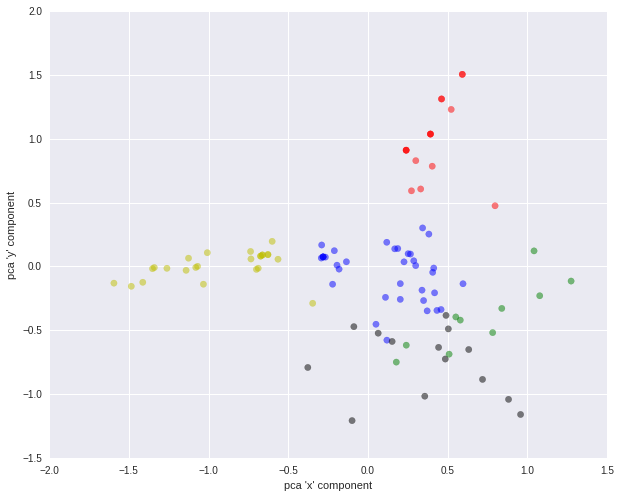

In [178]:
#your turn

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

colorindex = ['r', 'g', 'b', 'y', 'k']
colors = []
for i in range(0,len(cluster_predict)):
    colors.append(colorindex[cluster_predict[i]])

plt.figure(figsize=(10,8))
plt.scatter(cluster_df['x'], cluster_df['y'], color=colors, s=40, alpha=0.5)
#plt.scatter(cluster_df['x'], cluster_df['y'], )
plt.xlabel('pca \'x\' component')
plt.ylabel('pca \'y\' component')
plt.show()

**Your turn (extra credit):** Play with the following: 

* Different initializations for `KMeans`
* Other clustering algorithms in scikit-learn